# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_120  G3XAK1;P26927     16.088
Sample_184  Q8WY91            18.888
Sample_029  O76061            15.650
Sample_104  P53634            16.478
Sample_163  Q93063;Q93063-3   16.023
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups             
Sample_027  O94933                        14.283
Sample_179  G3V295;G3V3I1;G3V5Z7;P60900   10.316
Sample_204  P01912;Q5Y7A7                 16.068
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.962
            A0A075B6Q5                 13.061
            A0A075B6R2                 12.828
            A0A075B6S5                 10.986
            A0A087WSY4                 12.399
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.542
            Q9UI40;Q9UI40-2            11.391
            Q9UIW2                     12.548
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.014
            Q9UP79                     12.884
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.221,15.050,16.842,19.863,16.160,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.819,19.067,...,15.528,15.576,14.095,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,16.098,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.524,17.705,17.039,16.124,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.384,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.511,15.345,17.084,18.708,14.249,19.433,11.769,11.195
Sample_207,15.739,16.877,15.469,16.898,15.134,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,14.361,13.978,12.580,14.224,15.291,13.080,12.068,13.525,12.124,12.227
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.682,19.067,16.127,...,11.848,12.569,12.841,12.007,12.731,13.606,13.624,14.005,12.330,13.049
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.670,13.626,12.483,11.618,12.653,14.085,13.062,12.290,12.730,12.559
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.716,13.077,13.458,12.510,12.759,13.074,12.733,13.107,12.275,13.376
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.671,11.019,13.077,13.600,12.935,12.161,13.489,13.609,13.682,13.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.615,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 125.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

100%|██████████| 2/2 [00:00<00:00,  4.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.98it/s]

100%|██████████| 3/3 [00:00<00:00,  3.50it/s]

100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.46it/s]

100%|██████████| 4/4 [00:01<00:00,  2.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.12it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  2.79it/s]

100%|██████████| 5/5 [00:01<00:00,  3.22it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.31it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.58it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.13it/s]

100%|██████████| 6/6 [00:01<00:00,  2.89it/s]

100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.47it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.48it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.98it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.67it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.57it/s]

100%|██████████| 7/7 [00:01<00:00,  3.17it/s]

100%|██████████| 7/7 [00:01<00:00,  3.63it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.99it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.33it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.44it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.31it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.94it/s]

100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  8.44it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.96it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.93it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  4.58it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.54it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.51it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.41it/s]

100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.72it/s]

 30%|███       | 3/10 [00:00<00:01,  5.42it/s]

 40%|████      | 4/10 [00:00<00:01,  4.99it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.77it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.60it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.14it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.12it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.78it/s]

100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.77it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.72it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.11it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.27it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.81it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.53it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.43it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.94it/s]

100%|██████████| 11/11 [00:02<00:00,  3.37it/s]

100%|██████████| 11/11 [00:02<00:00,  4.26it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.36it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.76it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.23it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.89it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.94it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.05it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  4.14it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.36it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.36it/s]

100%|██████████| 12/12 [00:02<00:00,  4.22it/s]

100%|██████████| 12/12 [00:02<00:00,  4.27it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.80it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.19it/s]

 31%|███       | 4/13 [00:00<00:02,  4.36it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.36it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.30it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.26it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.18it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.04it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.90it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.63it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.66it/s]

100%|██████████| 13/13 [00:03<00:00,  3.73it/s]

100%|██████████| 13/13 [00:03<00:00,  4.11it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.01it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.53it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.72it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.55it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.46it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.55it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.62it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.72it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.81it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.86it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.90it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.84it/s]

100%|██████████| 14/14 [00:03<00:00,  3.82it/s]

100%|██████████| 14/14 [00:03<00:00,  3.83it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.97it/s]

 20%|██        | 3/15 [00:00<00:02,  5.03it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.27it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.94it/s]

 40%|████      | 6/15 [00:01<00:02,  3.32it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.06it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.87it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.75it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.71it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.95it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.20it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.48it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.69it/s]

100%|██████████| 15/15 [00:04<00:00,  3.74it/s]

100%|██████████| 15/15 [00:04<00:00,  3.45it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.001      0.039 0.007          0.877 0.203       0.160   
2             0.004 0.002      0.046 0.017          0.673 0.120       0.555   
3             0.006 0.003      0.061 0.020          0.698 0.109       0.646   
4             0.005 0.003      0.053 0.025          0.723 0.098       0.676   
5             0.006 0.004      0.064 0.025          0.714 0.093       0.685   
6             0.005 0.002      0.053 0.017          0.819 0.076       0.816   
7             0.006 0.003      0.058 0.023          0.825 0.077       0.823   
8             0.006 0.003      0.056 0.019          0.822 0.079       0.816   
9             0.005 0.002      0.054 0.020          0.820 0.080       0.809   
10            0.005 0.002      0.049 0.018          0.811 0.091       0.798   
11            0.005 0.002      0.050 0.019          0.821 0.094       0.823   
12            0.006 0.003      0.059 0.020          0.821 0.085       0.832   
13            0.005 0.002      0.048 0.014          0.819 0.084       0.830   
14            0.006 0.003      0.052 0.017          0.826 0.082       0.818   
15            0.005 0.001      0.046 0.016          0.821 0.085       0.814   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.261 0.123                  0.572 0.042        0.865   
2          0.108   0.601 0.087                  0.675 0.065        0.732   
3          0.125   0.663 0.092                  0.716 0.074        0.804   
4          0.116   0.692 0.083                  0.740 0.066        0.838   
5          0.111   0.693 0.079                  0.740 0.064        0.830   
6          0.102   0.813 0.067                  0.841 0.055        0.906   
7          0.100   0.820 0.066                  0.846 0.055        0.905   
8          0.106   0.814 0.069                  0.842 0.057        0.903   
9          0.107   0.810 0.069                  0.838 0.058        0.902   
10         0.103   0.799 0.073                  0.829 0.061        0.902   
11         0.095   0.817 0.071                  0.843 0.061        0.913   
12         0.094   0.823 0.068                  0.848 0.059        0.915   
13         0.094   0.821 0.069                  0.846 0.060        0.915   
14         0.086   0.819 0.066                  0.845 0.057        0.919   
15         0.086   0.814 0.068                  0.841 0.059        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.089        210.000 0.000  
2          0.077                  0.691 0.097        210.000 0.000  
3          0.074                  0.734 0.097        210.000 0.000  
4          0.062                  0.800 0.085        210.000 0.000  
5          0.055                  0.788 0.084        210.000 0.000  
6          0.044                  0.882 0.057        210.000 0.000  
7          0.047                  0.881 0.056        210.000 0.000  
8          0.046                  0.879 0.055        210.000 0.000  
9          0.047                  0.876 0.058        210.000 0.000  
10         0.048                  0.878 0.057        210.000 0.000  
11         0.047                  0.899 0.051        210.000 0.000  
12         0.047                  0.903 0.051        210.000 0.000  
13         0.047                  0.903 0.050        210.000 0.000  
14         0.045                  0.909 0.047        210.000 0.000  
15         0.045                  0.909 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 508.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.11it/s]

100%|██████████| 3/3 [00:00<00:00,  3.38it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.73it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.37it/s]

100%|██████████| 4/4 [00:00<00:00,  3.87it/s]

100%|██████████| 4/4 [00:00<00:00,  4.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.58it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.06it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.05it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

100%|██████████| 5/5 [00:01<00:00,  3.30it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.36it/s]

 50%|█████     | 3/6 [00:00<00:01,  2.86it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.66it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.55it/s]

100%|██████████| 6/6 [00:02<00:00,  2.64it/s]

100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.70it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.26it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.26it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.04it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.65it/s]

100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

100%|██████████| 7/7 [00:02<00:00,  3.04it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.69it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.27it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.77it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.23it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.01it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  1.96it/s]

100%|██████████| 8/8 [00:03<00:00,  1.98it/s]

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.24it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.94it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.33it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.36it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.65it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.37it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.19it/s]

100%|██████████| 9/9 [00:03<00:00,  2.11it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.22it/s]

 30%|███       | 3/10 [00:00<00:01,  4.28it/s]

 40%|████      | 4/10 [00:00<00:01,  3.93it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.75it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.68it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.64it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.28it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.91it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

100%|██████████| 10/10 [00:03<00:00,  3.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.10it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.15it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.41it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.32it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.95it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.68it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.63it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.32it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.21it/s]

100%|██████████| 11/11 [00:04<00:00,  2.17it/s]

100%|██████████| 11/11 [00:04<00:00,  2.71it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.22it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.04it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.47it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.24it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.38it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.44it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.52it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.62it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.36it/s]

100%|██████████| 12/12 [00:03<00:00,  2.95it/s]

100%|██████████| 12/12 [00:03<00:00,  3.38it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.90it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.46it/s]

 31%|███       | 4/13 [00:00<00:02,  4.03it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.91it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.83it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.79it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.77it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.65it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.13it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.76it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.54it/s]

100%|██████████| 13/13 [00:04<00:00,  2.33it/s]

100%|██████████| 13/13 [00:04<00:00,  3.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.05it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.98it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.06it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.54it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.45it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.45it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.62it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.68it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.70it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.83it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.86it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.91it/s]

100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.62it/s]

 20%|██        | 3/15 [00:00<00:02,  5.51it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.19it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.98it/s]

 40%|████      | 6/15 [00:01<00:02,  3.94it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.99it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.83it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.55it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.26it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.28it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.36it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.35it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

100%|██████████| 15/15 [00:04<00:00,  3.69it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.058 0.024          0.010 0.071       0.001   
2             0.004 0.002      0.046 0.014          0.767 0.120       0.630   
3             0.005 0.003      0.051 0.020          0.757 0.089       0.679   
4             0.004 0.001      0.041 0.012          0.753 0.094       0.671   
5             0.003 0.001      0.036 0.011          0.743 0.097       0.665   
6             0.004 0.001      0.038 0.009          0.739 0.095       0.675   
7             0.005 0.002      0.045 0.015          0.744 0.103       0.690   
8             0.006 0.003      0.058 0.027          0.746 0.102       0.695   
9             0.005 0.002      0.050 0.019          0.756 0.096       0.744   
10            0.007 0.003      0.071 0.028          0.777 0.094       0.756   
11            0.005 0.002      0.048 0.014          0.791 0.085       0.797   
12            0.006 0.002      0.068 0.022          0.801 0.095       0.804   
13            0.006 0.003      0.059 0.023          0.800 0.094       0.802   
14            0.004 0.001      0.040 0.009          0.796 0.088       0.804   
15            0.006 0.003      0.053 0.020          0.796 0.088       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.861   
2          0.125   0.682 0.096                  0.740 0.073        0.788   
3          0.120   0.710 0.086                  0.759 0.065        0.852   
4          0.118   0.704 0.088                  0.754 0.067        0.850   
5          0.129   0.695 0.091                  0.747 0.071        0.866   
6          0.130   0.698 0.092                  0.749 0.071        0.866   
7          0.133   0.710 0.100                  0.757 0.080        0.874   
8          0.129   0.713 0.097                  0.760 0.078        0.872   
9          0.125   0.746 0.095                  0.784 0.079        0.884   
10         0.130   0.761 0.098                  0.798 0.081        0.889   
11         0.115   0.789 0.081                  0.820 0.068        0.914   
12         0.113   0.798 0.085                  0.827 0.072        0.916   
13         0.112   0.796 0.084                  0.826 0.071        0.915   
14         0.107   0.795 0.080                  0.825 0.068        0.913   
15         0.097   0.791 0.074                  0.821 0.063        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.086        210.000 0.000  
2          0.076                  0.734 0.096        210.000 0.000  
3          0.059                  0.819 0.072        210.000 0.000  
4          0.060                  0.817 0.070        210.000 0.000  
5          0.055                  0.838 0.065        210.000 0.000  
6          0.055                  0.839 0.064        210.000 0.000  
7          0.060                  0.848 0.069        210.000 0.000  
8          0.059                  0.844 0.068        210.000 0.000  
9          0.057                  0.867 0.063        210.000 0.000  
10         0.055                  0.866 0.065        210.000 0.000  
11         0.046                  0.892 0.054        210.000 0.000  
12         0.047                  0.896 0.054        210.000 0.000  
13         0.047                  0.895 0.054        210.000 0.000  
14         0.047                  0.891 0.056        210.000 0.000  
15         0.045                  0.894 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1019.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 26.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 18.98it/s]

100%|██████████| 3/3 [00:00<00:00, 18.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 24.96it/s]

100%|██████████| 4/4 [00:00<00:00, 21.42it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.14it/s]

100%|██████████| 5/5 [00:00<00:00, 13.95it/s]

100%|██████████| 5/5 [00:00<00:00, 14.51it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.43it/s]

100%|██████████| 6/6 [00:00<00:00, 15.85it/s]

100%|██████████| 6/6 [00:00<00:00, 16.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 16.83it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.51it/s]

100%|██████████| 7/7 [00:00<00:00, 12.27it/s]

100%|██████████| 7/7 [00:00<00:00, 12.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.95it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 16.40it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.30it/s]

100%|██████████| 8/8 [00:00<00:00, 14.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 20.39it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.82it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 11.51it/s]

100%|██████████| 9/9 [00:00<00:00, 12.17it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.58it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.68it/s]

 70%|███████   | 7/10 [00:00<00:00, 14.00it/s]

100%|██████████| 10/10 [00:00<00:00, 15.26it/s]

100%|██████████| 10/10 [00:00<00:00, 15.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 30.76it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.66it/s]

100%|██████████| 11/11 [00:00<00:00, 16.97it/s]

100%|██████████| 11/11 [00:00<00:00, 17.96it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 21.68it/s]

 50%|█████     | 6/12 [00:00<00:00, 17.16it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 17.07it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 16.26it/s]

100%|██████████| 12/12 [00:00<00:00, 16.51it/s]

100%|██████████| 12/12 [00:00<00:00, 16.91it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.73it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.37it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.99it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.30it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 15.51it/s]

100%|██████████| 13/13 [00:00<00:00, 16.62it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.92it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.39it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.45it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.05it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.77it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.77it/s]

100%|██████████| 14/14 [00:01<00:00, 13.46it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 14.68it/s]

 33%|███▎      | 5/15 [00:00<00:00, 11.61it/s]

 47%|████▋     | 7/15 [00:00<00:00, 10.24it/s]

 60%|██████    | 9/15 [00:00<00:00, 11.35it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.39it/s]

 87%|████████▋ | 13/15 [00:01<00:00, 11.75it/s]

100%|██████████| 15/15 [00:01<00:00, 12.01it/s]

100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.044 0.012          0.000 0.000       0.000   
2             0.004 0.002      0.049 0.017          0.581 0.124       0.358   
3             0.005 0.002      0.053 0.021          0.636 0.102       0.475   
4             0.004 0.001      0.040 0.009          0.663 0.097       0.531   
5             0.005 0.002      0.050 0.019          0.660 0.103       0.527   
6             0.003 0.001      0.037 0.006          0.660 0.100       0.531   
7             0.005 0.003      0.052 0.020          0.647 0.105       0.513   
8             0.004 0.002      0.042 0.011          0.657 0.099       0.502   
9             0.005 0.002      0.049 0.017          0.651 0.089       0.590   
10            0.003 0.001      0.030 0.009          0.652 0.085       0.625   
11            0.005 0.002      0.045 0.015          0.664 0.074       0.637   
12            0.006 0.002      0.055 0.020          0.680 0.088       0.647   
13            0.007 0.005      0.065 0.029          0.677 0.087       0.639   
14            0.005 0.002      0.048 0.017          0.678 0.095       0.640   
15            0.006 0.003      0.056 0.019          0.676 0.094       0.635   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.737   
2          0.103   0.437 0.107                  0.586 0.058        0.639   
3          0.091   0.537 0.074                  0.635 0.052        0.699   
4          0.109   0.582 0.082                  0.664 0.056        0.727   
5          0.112   0.577 0.087                  0.661 0.061        0.722   
6          0.116   0.580 0.089                  0.662 0.061        0.715   
7          0.126   0.562 0.097                  0.651 0.065        0.712   
8          0.115   0.559 0.087                  0.651 0.056        0.715   
9          0.113   0.612 0.081                  0.677 0.063        0.760   
10         0.103   0.632 0.071                  0.688 0.058        0.783   
11         0.095   0.645 0.065                  0.699 0.053        0.796   
12         0.117   0.656 0.083                  0.710 0.065        0.795   
13         0.120   0.650 0.084                  0.706 0.064        0.793   
14         0.117   0.651 0.085                  0.706 0.066        0.790   
15         0.108   0.647 0.079                  0.702 0.063        0.788   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.687 0.085        210.000 0.000  
2          0.067                  0.582 0.075        210.000 0.000  
3          0.067                  0.662 0.076        210.000 0.000  
4          0.072                  0.685 0.077        210.000 0.000  
5          0.074                  0.682 0.081        210.000 0.000  
6          0.072                  0.675 0.080        210.000 0.000  
7          0.070                  0.663 0.084        210.000 0.000  
8          0.067                  0.667 0.082        210.000 0.000  
9          0.069                  0.709 0.084        210.000 0.000  
10         0.063                  0.732 0.080        210.000 0.000  
11         0.064                  0.738 0.089        210.000 0.000  
12         0.064                  0.736 0.085        210.000 0.000  
13         0.063                  0.733 0.083        210.000 0.000  
14         0.062                  0.736 0.080        210.000 0.000  
15         0.062                  0.734 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,10,13
score_time,5,10,13
test_precision,1,12,12
test_recall,12,12,12
test_f1,12,12,12
test_balanced_accuracy,12,12,12
test_roc_auc,14,12,11
test_average_precision,14,12,11
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.65it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.65it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.17it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.17it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.94it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.73it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.64it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.57it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.63it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.63it/s]

100%|██████████| 12/12 [00:03<00:00,  3.14it/s]

100%|██████████| 12/12 [00:03<00:00,  3.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.04it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.72it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.84it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.98it/s]

 91%|█████████ | 10/11 [00:00<00:00, 11.52it/s]

100%|██████████| 11/11 [00:00<00:00, 11.18it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  9.03it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.68it/s]

 29%|██▊       | 4/14 [00:00<00:01,  6.17it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.86it/s]

 43%|████▎     | 6/14 [00:00<00:01,  5.69it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.45it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.36it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.20it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  4.98it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.96it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.66it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  3.80it/s]

100%|██████████| 14/14 [00:02<00:00,  3.37it/s]

100%|██████████| 14/14 [00:02<00:00,  4.67it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


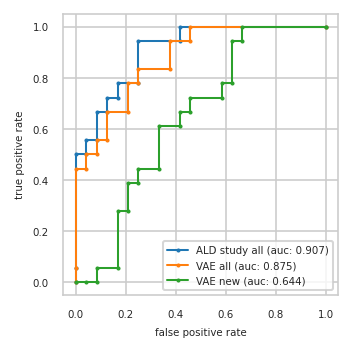

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.500   0.000 0.444   0.083 0.000
3          0.042 0.500   0.042 0.444   0.083 0.056
4          0.042 0.556   0.042 0.500   0.167 0.056
5          0.083 0.556   0.083 0.500   0.167 0.278
6          0.083 0.667   0.083 0.556   0.208 0.278
7          0.125 0.667   0.125 0.556   0.208 0.389
8          0.125 0.722   0.125 0.667   0.250 0.389
9          0.167 0.722   0.208 0.667   0.250 0.444
10         0.167 0.778   0.208 0.778   0.333 0.444
11         0.250 0.778   0.250 0.778   0.333 0.611
12         0.250 0.944   0.250 0.833   0.417 0.611
13         0.417 0.944   0.375 0.833   0.417 0.667
14         0.417 1.000   0.375 0.944   0.458 0.667
15         1.000 1.000   0.458 0.944   0.458 0.722
16           NaN   NaN   0.458 1.000   0.583 0.722
17           NaN   NaN   1.000 1.000   0.583 0.778
18           NaN   NaN     NaN   NaN   0.625 0.778
19           NaN   NaN     NaN   NaN   0.625 0.944
20           NaN   NaN     NaN   NaN   0.667 0.944
21           NaN   NaN     NaN   NaN   0.667 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P01701,Q92542;Q92542-2,Q9NUQ9
2,P04114,P07093-2;P07093-3,H0Y7T8;P49418;P49418-2
3,Q8NCL4,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
4,P61981,Q9Y2T3;Q9Y2T3-3,Q96GD0
5,P09960;P09960-4,A0A0B4J1Z1;C9JAB2;Q16629;Q16629-2;Q16629-3;Q16...,P31321
6,Q9Y2T3;Q9Y2T3-3,P04075,J3KSJ8;Q9UD71;Q9UD71-2
7,P04075,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P14174,P15151-2,P51688


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


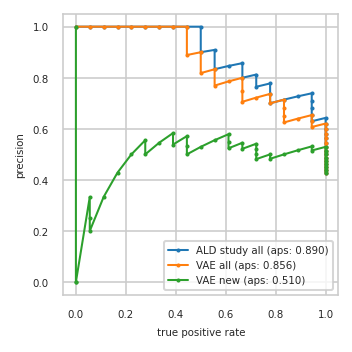

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.515 0.944
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.621 1.000     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.630 0.944     0.630 0.944     0.481 0.722
16         0.654 0.944     0.654 0.944     0.500 0.722
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.708 0.944     0.625 0.833     0.542 0.722
19         0.739 0.944     0.652 0.833     0.522 0.667
20         0.727 0.889     0.682 0.833     0.545 0.667
21         0.714 0.833     0.714 0.833     0.524 0.611
22         0.700 0.778     0.700 0.778     0.550 0.611
23         0.737 0.778     0.737 0.778     0.579 0.611
24         0.778 0.778     0.722 0.722     0.556 0.556
25         0.765 0.722     0.706 0.667     0.529 0.500
26         0.812 0.722     0.750 0.667     0.500 0.444
27         0.800 0.667     0.800 0.667     0.533 0.444
28         0.857 0.667     0.786 0.611     0.571 0.444
29         0.846 0.611     0.769 0.556     0.538 0.389
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.909 0.556     0.818 0.500     0.545 0.333
32         0.900 0.500     0.900 0.500     0.500 0.278
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     1.000 0.444     0.500 0.222
35         1.000 0.389     1.000 0.389     0.429 0.167
36         1.000 0.333     1.000 0.333     0.333 0.111
37         1.000 0.278     1.000 0.278     0.200 0.056
38         1.000 0.222     1.000 0.222     0.250 0.056
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


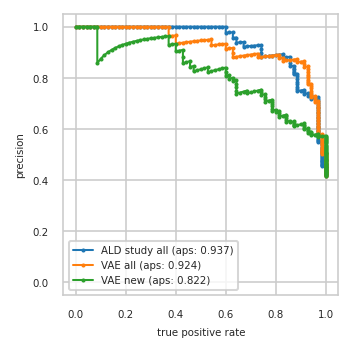

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


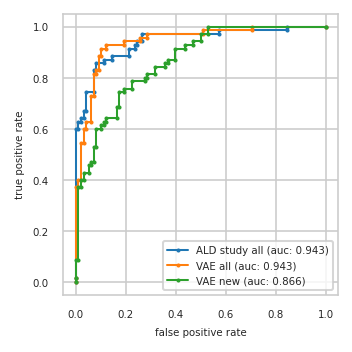

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}